# Generating Arts using GANs

## Importing the modules

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing the data

In [2]:
artists = pd.read_csv("../input/best-artworks-of-all-time/artists.csv")

for i in artists['name']:
    print(i)

Amedeo Modigliani
Vasiliy Kandinskiy
Diego Rivera
Claude Monet
Rene Magritte
Salvador Dali
Edouard Manet
Andrei Rublev
Vincent van Gogh
Gustav Klimt
Hieronymus Bosch
Kazimir Malevich
Mikhail Vrubel
Pablo Picasso
Peter Paul Rubens
Pierre-Auguste Renoir
Francisco Goya
Frida Kahlo
El Greco
Albrecht Dürer
Alfred Sisley
Pieter Bruegel
Marc Chagall
Giotto di Bondone
Sandro Botticelli
Caravaggio
Leonardo da Vinci
Diego Velazquez
Henri Matisse
Jan van Eyck
Edgar Degas
Rembrandt
Titian
Henri de Toulouse-Lautrec
Gustave Courbet
Camille Pissarro
William Turner
Edvard Munch
Paul Cezanne
Eugene Delacroix
Henri Rousseau
Georges Seurat
Paul Klee
Piet Mondrian
Joan Miro
Andy Warhol
Paul Gauguin
Raphael
Michelangelo
Jackson Pollock


In [3]:
batch_size = 128
image_size = (64, 64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
                                   # transforms.RandomCrop(32, padding=2),
                                   # transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="../input/best-artworks-of-all-time/resized",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

8683


torch.Size([3, 64, 64])


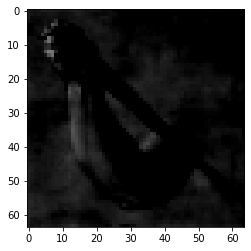

In [5]:
images,_ = train_ds[465]
print(images.size())
plt.imshow(images.permute(1,2,0))

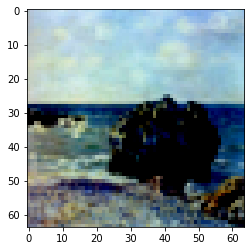

In [6]:
images,_ = train_ds[798]
plt.imshow(images.permute(1,2,0))

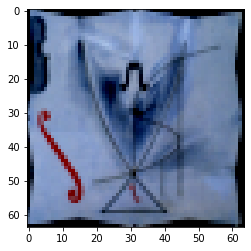

In [7]:
images,_ = train_ds[7165]
plt.imshow(images.permute(1,2,0))

In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

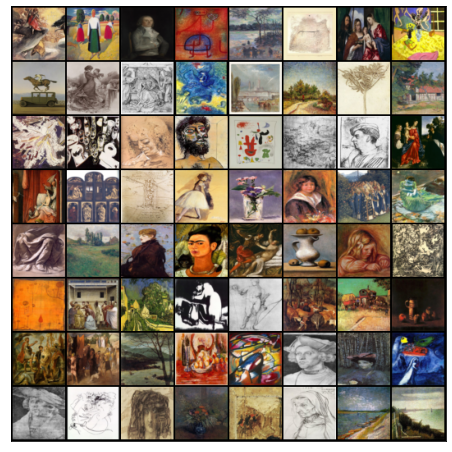

In [10]:
show_batch(train_dl)

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [15]:
discriminator = to_device(discriminator, device)

In [16]:
latent_size = 128

In [17]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

## Defining the model

torch.Size([128, 3, 64, 64])


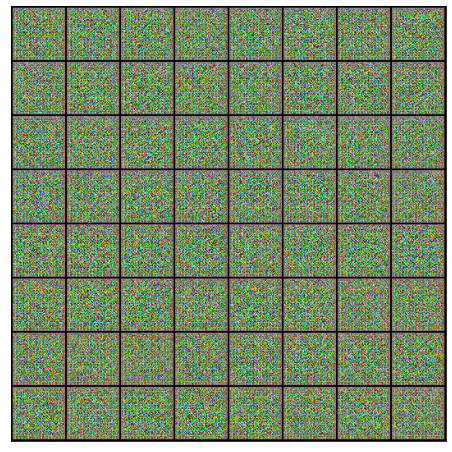

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator = to_device(generator, device)

In [20]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [21]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [22]:
from torchvision.utils import save_image

In [23]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [25]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


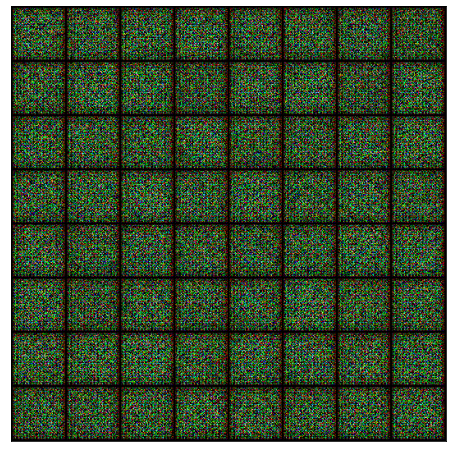

In [26]:
save_samples(0, fixed_latent)

In [27]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.001
epochs = 150

In [29]:
history = fit(epochs,lr)

  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 2.7238, loss_d: 0.2609, real_score: 0.8635, fake_score: 0.1000
Saving generated-images-0001.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 2.1850, loss_d: 1.2576, real_score: 0.6193, fake_score: 0.4354
Saving generated-images-0002.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 1.3812, loss_d: 0.9578, real_score: 0.5043, fake_score: 0.1680
Saving generated-images-0003.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 2.1691, loss_d: 1.0296, real_score: 0.7152, fake_score: 0.4461
Saving generated-images-0004.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 5.7925, loss_d: 1.6729, real_score: 0.9345, fake_score: 0.7673
Saving generated-images-0005.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 0.6847, loss_d: 1.3051, real_score: 0.4128, fake_score: 0.1864
Saving generated-images-0006.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 1.6040, loss_d: 0.9589, real_score: 0.6465, fake_score: 0.3495
Saving generated-images-0007.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 3.1736, loss_d: 0.8717, real_score: 0.8522, fake_score: 0.4840
Saving generated-images-0008.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 2.4194, loss_d: 0.7711, real_score: 0.6558, fake_score: 0.2394
Saving generated-images-0009.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 1.2071, loss_d: 1.7867, real_score: 0.2494, fake_score: 0.1668
Saving generated-images-0010.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 3.3588, loss_d: 0.6120, real_score: 0.7146, fake_score: 0.2049
Saving generated-images-0011.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 3.7902, loss_d: 1.3845, real_score: 0.9048, fake_score: 0.6714
Saving generated-images-0012.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 0.5961, loss_d: 1.4380, real_score: 0.2869, fake_score: 0.0184
Saving generated-images-0013.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 6.4728, loss_d: 1.4183, real_score: 0.8322, fake_score: 0.6566
Saving generated-images-0014.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 2.7993, loss_d: 0.7230, real_score: 0.8192, fake_score: 0.3739
Saving generated-images-0015.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 4.2935, loss_d: 0.9061, real_score: 0.7824, fake_score: 0.4094
Saving generated-images-0016.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 2.5939, loss_d: 0.5526, real_score: 0.6834, fake_score: 0.1083
Saving generated-images-0017.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 2.8464, loss_d: 0.7939, real_score: 0.8543, fake_score: 0.4220
Saving generated-images-0018.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 3.6797, loss_d: 0.6274, real_score: 0.6419, fake_score: 0.0988
Saving generated-images-0019.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 3.1899, loss_d: 1.0807, real_score: 0.4324, fake_score: 0.0546
Saving generated-images-0020.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 2.7779, loss_d: 0.5353, real_score: 0.7503, fake_score: 0.1793
Saving generated-images-0021.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 3.0917, loss_d: 0.5811, real_score: 0.8411, fake_score: 0.3079
Saving generated-images-0022.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 0.5709, loss_d: 1.6349, real_score: 0.2856, fake_score: 0.0201
Saving generated-images-0023.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 7.0305, loss_d: 1.4277, real_score: 0.8777, fake_score: 0.6415
Saving generated-images-0024.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 1.9147, loss_d: 0.5814, real_score: 0.7090, fake_score: 0.1470
Saving generated-images-0025.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 2.6975, loss_d: 1.5354, real_score: 0.2909, fake_score: 0.0278
Saving generated-images-0026.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 3.5180, loss_d: 0.3266, real_score: 0.8251, fake_score: 0.0933
Saving generated-images-0027.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 3.5422, loss_d: 0.6521, real_score: 0.7334, fake_score: 0.2288
Saving generated-images-0028.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 3.2473, loss_d: 1.0607, real_score: 0.6669, fake_score: 0.4146
Saving generated-images-0029.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 3.2333, loss_d: 0.4893, real_score: 0.7006, fake_score: 0.0719
Saving generated-images-0030.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 3.0844, loss_d: 0.5929, real_score: 0.7438, fake_score: 0.2208
Saving generated-images-0031.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 3.1901, loss_d: 0.9233, real_score: 0.6403, fake_score: 0.2998
Saving generated-images-0032.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 3.0750, loss_d: 0.8849, real_score: 0.5034, fake_score: 0.0437
Saving generated-images-0033.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 2.5293, loss_d: 0.6092, real_score: 0.6707, fake_score: 0.1081
Saving generated-images-0034.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 4.8981, loss_d: 0.9254, real_score: 0.8443, fake_score: 0.4324
Saving generated-images-0035.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 2.9359, loss_d: 0.5907, real_score: 0.8681, fake_score: 0.3127
Saving generated-images-0036.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 2.6811, loss_d: 0.7253, real_score: 0.7414, fake_score: 0.2771
Saving generated-images-0037.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 2.3056, loss_d: 0.9685, real_score: 0.5593, fake_score: 0.1634
Saving generated-images-0038.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 1.2472, loss_d: 1.5287, real_score: 0.3700, fake_score: 0.1348
Saving generated-images-0039.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 2.8220, loss_d: 0.8737, real_score: 0.6937, fake_score: 0.2907
Saving generated-images-0040.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 3.4604, loss_d: 0.5296, real_score: 0.8402, fake_score: 0.2379
Saving generated-images-0041.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 3.4270, loss_d: 0.9079, real_score: 0.6991, fake_score: 0.3147
Saving generated-images-0042.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 2.5363, loss_d: 0.7342, real_score: 0.6174, fake_score: 0.0972
Saving generated-images-0043.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 2.2149, loss_d: 0.6103, real_score: 0.7914, fake_score: 0.2673
Saving generated-images-0044.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 1.3705, loss_d: 0.8472, real_score: 0.5141, fake_score: 0.0679
Saving generated-images-0045.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 2.9819, loss_d: 0.5576, real_score: 0.8476, fake_score: 0.2848
Saving generated-images-0046.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 4.3906, loss_d: 0.6381, real_score: 0.8780, fake_score: 0.3427
Saving generated-images-0047.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 2.7502, loss_d: 0.6106, real_score: 0.7375, fake_score: 0.1990
Saving generated-images-0048.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 5.8488, loss_d: 1.0595, real_score: 0.9372, fake_score: 0.5532
Saving generated-images-0049.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 2.3722, loss_d: 0.7722, real_score: 0.6780, fake_score: 0.2423
Saving generated-images-0050.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 1.5210, loss_d: 1.0987, real_score: 0.4706, fake_score: 0.1167
Saving generated-images-0051.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 3.5095, loss_d: 0.6952, real_score: 0.7268, fake_score: 0.2267
Saving generated-images-0052.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 5.1773, loss_d: 1.2191, real_score: 0.9537, fake_score: 0.6157
Saving generated-images-0053.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 3.6129, loss_d: 0.8045, real_score: 0.7912, fake_score: 0.3603
Saving generated-images-0054.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 3.3871, loss_d: 0.6007, real_score: 0.7521, fake_score: 0.2066
Saving generated-images-0055.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 2.5672, loss_d: 1.2559, real_score: 0.3722, fake_score: 0.0215
Saving generated-images-0056.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 3.1406, loss_d: 0.6303, real_score: 0.6755, fake_score: 0.0949
Saving generated-images-0057.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 2.0940, loss_d: 0.4932, real_score: 0.7415, fake_score: 0.1109
Saving generated-images-0058.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 2.1825, loss_d: 1.2291, real_score: 0.4235, fake_score: 0.0342
Saving generated-images-0059.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 3.8230, loss_d: 0.4933, real_score: 0.7829, fake_score: 0.1588
Saving generated-images-0060.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 5.2207, loss_d: 0.7045, real_score: 0.9333, fake_score: 0.3867
Saving generated-images-0061.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 0.8720, loss_d: 1.2342, real_score: 0.4103, fake_score: 0.0529
Saving generated-images-0062.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 4.0446, loss_d: 0.6617, real_score: 0.8155, fake_score: 0.2865
Saving generated-images-0063.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 4.9220, loss_d: 0.3074, real_score: 0.8083, fake_score: 0.0658
Saving generated-images-0064.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 2.6676, loss_d: 0.4544, real_score: 0.7689, fake_score: 0.1234
Saving generated-images-0065.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 2.5631, loss_d: 0.6480, real_score: 0.6200, fake_score: 0.0393
Saving generated-images-0066.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 1.8398, loss_d: 0.6672, real_score: 0.6305, fake_score: 0.0821
Saving generated-images-0067.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 4.9627, loss_d: 2.2742, real_score: 0.9022, fake_score: 0.6681
Saving generated-images-0068.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 5.2567, loss_d: 1.3368, real_score: 0.9367, fake_score: 0.6404
Saving generated-images-0069.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 3.2384, loss_d: 0.4310, real_score: 0.8093, fake_score: 0.1472
Saving generated-images-0070.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 4.8330, loss_d: 0.5076, real_score: 0.9169, fake_score: 0.2904
Saving generated-images-0071.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 1.9790, loss_d: 0.5652, real_score: 0.6915, fake_score: 0.0961
Saving generated-images-0072.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 4.4742, loss_d: 0.3667, real_score: 0.9181, fake_score: 0.2086
Saving generated-images-0073.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 5.7529, loss_d: 0.8830, real_score: 0.9685, fake_score: 0.4560
Saving generated-images-0074.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 8.4796, loss_d: 1.6893, real_score: 0.9778, fake_score: 0.7202
Saving generated-images-0075.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 5.6102, loss_d: 1.3107, real_score: 0.9898, fake_score: 0.6357
Saving generated-images-0076.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 5.3633, loss_d: 0.1529, real_score: 0.9124, fake_score: 0.0497
Saving generated-images-0077.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 2.7492, loss_d: 0.3182, real_score: 0.8363, fake_score: 0.0992
Saving generated-images-0078.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 6.3583, loss_d: 0.1262, real_score: 0.9552, fake_score: 0.0636
Saving generated-images-0079.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 4.4050, loss_d: 0.3598, real_score: 0.9341, fake_score: 0.1630
Saving generated-images-0080.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 7.2652, loss_d: 1.4698, real_score: 0.9977, fake_score: 0.6642
Saving generated-images-0081.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 4.1219, loss_d: 0.1038, real_score: 0.9669, fake_score: 0.0539
Saving generated-images-0082.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 4.9772, loss_d: 0.4233, real_score: 0.9845, fake_score: 0.2757
Saving generated-images-0083.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 3.7837, loss_d: 0.2612, real_score: 0.8292, fake_score: 0.0453
Saving generated-images-0084.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 3.3890, loss_d: 0.2974, real_score: 0.8168, fake_score: 0.0501
Saving generated-images-0085.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 1.9540, loss_d: 0.5772, real_score: 0.7286, fake_score: 0.1184
Saving generated-images-0086.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 3.6893, loss_d: 0.1887, real_score: 0.9110, fake_score: 0.0684
Saving generated-images-0087.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 3.5733, loss_d: 0.9811, real_score: 0.5267, fake_score: 0.0317
Saving generated-images-0088.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 1.7949, loss_d: 2.7675, real_score: 0.2905, fake_score: 0.0071
Saving generated-images-0089.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 5.1114, loss_d: 0.2722, real_score: 0.9699, fake_score: 0.1602
Saving generated-images-0090.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 3.2223, loss_d: 0.2590, real_score: 0.8368, fake_score: 0.0388
Saving generated-images-0091.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 4.2706, loss_d: 0.3343, real_score: 0.9401, fake_score: 0.1997
Saving generated-images-0092.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 4.2872, loss_d: 0.2710, real_score: 0.8399, fake_score: 0.0431
Saving generated-images-0093.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 7.1354, loss_d: 0.2851, real_score: 0.8028, fake_score: 0.0174
Saving generated-images-0094.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 3.7674, loss_d: 0.3848, real_score: 0.8325, fake_score: 0.1098
Saving generated-images-0095.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 4.5310, loss_d: 0.2260, real_score: 0.9009, fake_score: 0.0858
Saving generated-images-0096.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 5.0989, loss_d: 0.5826, real_score: 0.6341, fake_score: 0.0029
Saving generated-images-0097.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 1.9899, loss_d: 1.4128, real_score: 0.4418, fake_score: 0.0402
Saving generated-images-0098.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 4.5898, loss_d: 0.2809, real_score: 0.8871, fake_score: 0.1121
Saving generated-images-0099.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 3.6689, loss_d: 0.0819, real_score: 0.9953, fake_score: 0.0694
Saving generated-images-0100.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 3.1528, loss_d: 0.3956, real_score: 0.8150, fake_score: 0.0673
Saving generated-images-0101.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 2.9099, loss_d: 0.3300, real_score: 0.7993, fake_score: 0.0407
Saving generated-images-0102.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 1.7497, loss_d: 0.7064, real_score: 0.6704, fake_score: 0.0724
Saving generated-images-0103.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 4.0835, loss_d: 0.6176, real_score: 0.9943, fake_score: 0.3121
Saving generated-images-0104.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 5.0390, loss_d: 0.2797, real_score: 0.9648, fake_score: 0.1729
Saving generated-images-0105.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 4.3247, loss_d: 0.1770, real_score: 0.9191, fake_score: 0.0585
Saving generated-images-0106.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 4.7902, loss_d: 0.1465, real_score: 0.9464, fake_score: 0.0766
Saving generated-images-0107.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 3.7676, loss_d: 0.1177, real_score: 0.9817, fake_score: 0.0872
Saving generated-images-0108.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 4.4071, loss_d: 0.1540, real_score: 0.9035, fake_score: 0.0375
Saving generated-images-0109.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 4.5982, loss_d: 0.2305, real_score: 0.8437, fake_score: 0.0180
Saving generated-images-0110.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 5.8154, loss_d: 1.5321, real_score: 0.7102, fake_score: 0.4332
Saving generated-images-0111.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 3.7793, loss_d: 0.8783, real_score: 0.5778, fake_score: 0.0400
Saving generated-images-0112.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 5.1471, loss_d: 0.2335, real_score: 0.8824, fake_score: 0.0689
Saving generated-images-0113.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 6.1359, loss_d: 0.3714, real_score: 0.9987, fake_score: 0.2517
Saving generated-images-0114.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 5.7163, loss_d: 0.0845, real_score: 0.9748, fake_score: 0.0492
Saving generated-images-0115.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 5.6764, loss_d: 0.0673, real_score: 0.9990, fake_score: 0.0594
Saving generated-images-0116.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 6.9706, loss_d: 0.0757, real_score: 0.9976, fake_score: 0.0579
Saving generated-images-0117.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 5.3707, loss_d: 0.1704, real_score: 0.9817, fake_score: 0.1078
Saving generated-images-0118.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 3.9889, loss_d: 0.2586, real_score: 0.8778, fake_score: 0.0581
Saving generated-images-0119.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 3.1694, loss_d: 0.3757, real_score: 0.8522, fake_score: 0.0735
Saving generated-images-0120.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 2.9900, loss_d: 0.2650, real_score: 0.8262, fake_score: 0.0284
Saving generated-images-0121.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 5.6675, loss_d: 0.1692, real_score: 0.9747, fake_score: 0.1008
Saving generated-images-0122.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 5.0799, loss_d: 0.0991, real_score: 0.9364, fake_score: 0.0231
Saving generated-images-0123.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 4.2244, loss_d: 0.3006, real_score: 0.7937, fake_score: 0.0072
Saving generated-images-0124.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 6.5083, loss_d: 0.0813, real_score: 0.9382, fake_score: 0.0092
Saving generated-images-0125.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 5.3003, loss_d: 0.0811, real_score: 0.9532, fake_score: 0.0162
Saving generated-images-0126.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 3.2570, loss_d: 2.0396, real_score: 0.6392, fake_score: 0.3165
Saving generated-images-0127.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 4.3565, loss_d: 0.3123, real_score: 0.9797, fake_score: 0.1757
Saving generated-images-0128.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 5.7919, loss_d: 0.1623, real_score: 0.9642, fake_score: 0.1007
Saving generated-images-0129.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 6.2455, loss_d: 0.0708, real_score: 0.9842, fake_score: 0.0475
Saving generated-images-0130.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 7.2543, loss_d: 0.1941, real_score: 0.9987, fake_score: 0.1502
Saving generated-images-0131.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 5.1191, loss_d: 0.0814, real_score: 0.9473, fake_score: 0.0232
Saving generated-images-0132.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 5.9920, loss_d: 0.0646, real_score: 0.9712, fake_score: 0.0305
Saving generated-images-0133.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 1.9604, loss_d: 0.5691, real_score: 0.6985, fake_score: 0.0168
Saving generated-images-0134.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 5.5374, loss_d: 0.1344, real_score: 0.9763, fake_score: 0.0893
Saving generated-images-0135.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 3.5818, loss_d: 1.0453, real_score: 0.5408, fake_score: 0.0033
Saving generated-images-0136.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 4.4643, loss_d: 0.1670, real_score: 0.8916, fake_score: 0.0193
Saving generated-images-0137.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 4.0406, loss_d: 0.2046, real_score: 0.8642, fake_score: 0.0128
Saving generated-images-0138.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 6.2175, loss_d: 0.0477, real_score: 0.9854, fake_score: 0.0306
Saving generated-images-0139.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 6.8263, loss_d: 0.0335, real_score: 0.9870, fake_score: 0.0191
Saving generated-images-0140.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 6.0630, loss_d: 0.1144, real_score: 0.9933, fake_score: 0.0856
Saving generated-images-0141.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 4.1724, loss_d: 0.3339, real_score: 0.9222, fake_score: 0.1105
Saving generated-images-0142.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 3.3849, loss_d: 0.2141, real_score: 0.8706, fake_score: 0.0365
Saving generated-images-0143.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 5.5139, loss_d: 0.2461, real_score: 0.8270, fake_score: 0.0054
Saving generated-images-0144.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 5.5989, loss_d: 0.0956, real_score: 0.9915, fake_score: 0.0712
Saving generated-images-0145.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 2.9803, loss_d: 0.2165, real_score: 0.8502, fake_score: 0.0116
Saving generated-images-0146.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 3.2163, loss_d: 6.1521, real_score: 0.5117, fake_score: 0.3012
Saving generated-images-0147.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 6.5707, loss_d: 0.4441, real_score: 0.9921, fake_score: 0.2590
Saving generated-images-0148.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 4.8519, loss_d: 0.1072, real_score: 0.9853, fake_score: 0.0697
Saving generated-images-0149.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 6.1080, loss_d: 0.1317, real_score: 0.9392, fake_score: 0.0449
Saving generated-images-0150.png


In [31]:
from IPython.display import Image

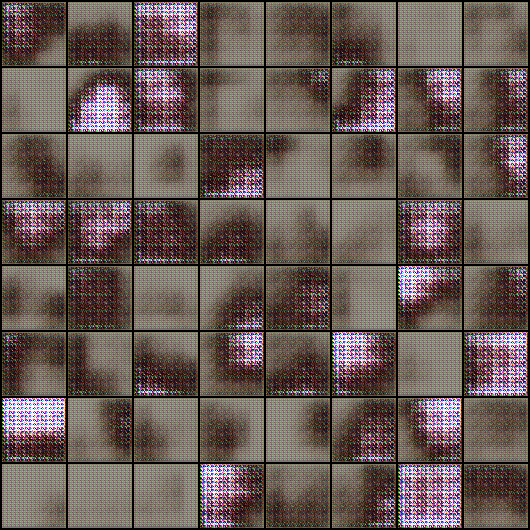

In [32]:
Image('./generated/generated-images-0001.png')

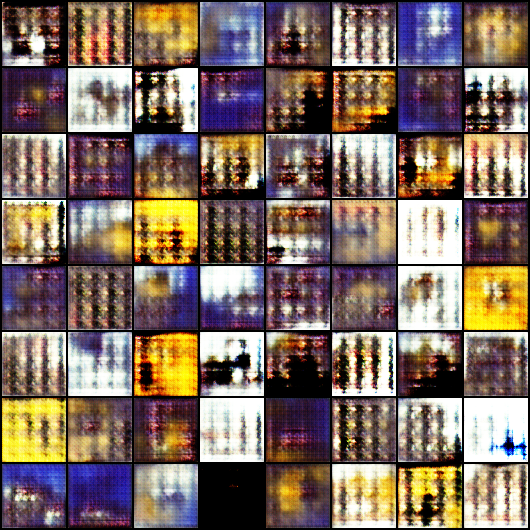

In [33]:
Image('./generated/generated-images-0030.png')

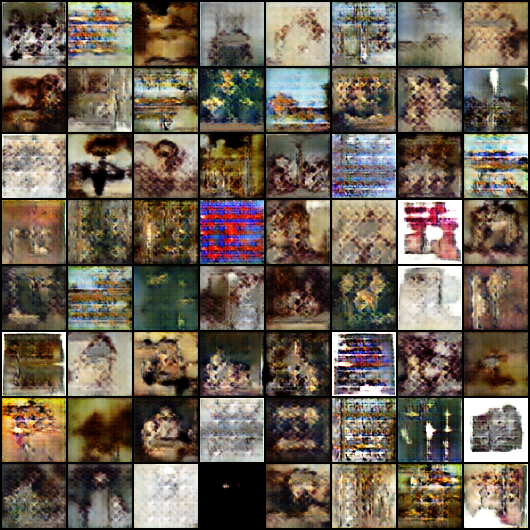

In [34]:
Image('./generated/generated-images-0060.png')

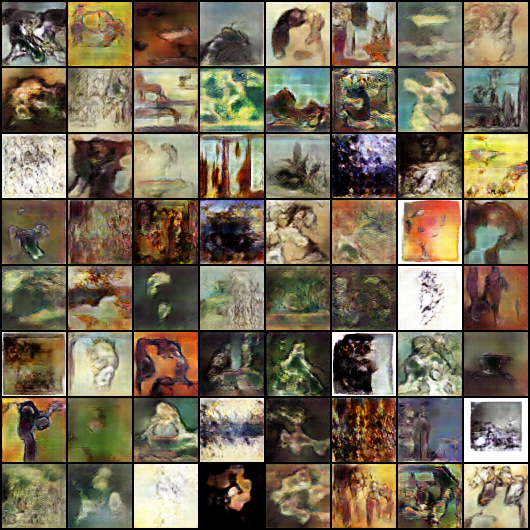

In [35]:
Image('./generated/generated-images-0090.png')

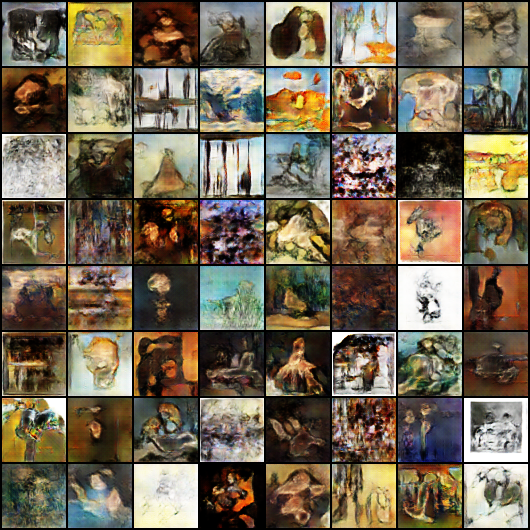

In [36]:
Image('./generated/generated-images-0120.png')

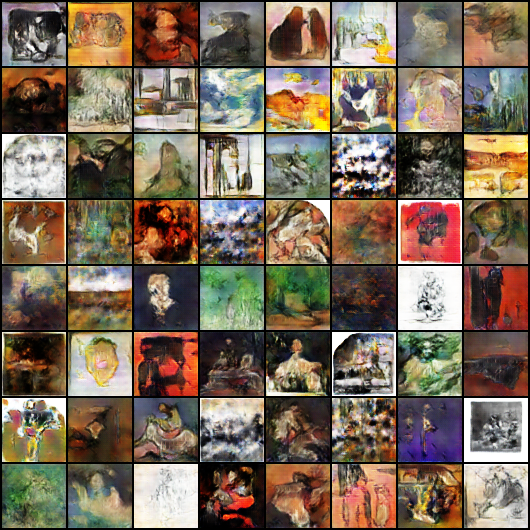

In [37]:
Image('./generated/generated-images-0140.png')

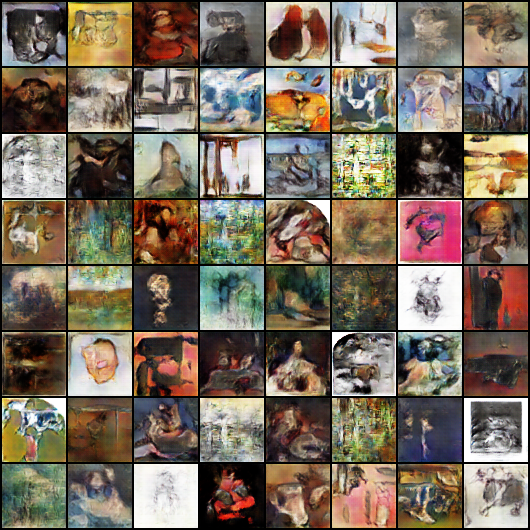

In [38]:
Image('./generated/generated-images-0150.png')

In [41]:
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [42]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project="Generating Arts using GANs", environment=None)

In [ ]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()